## Segundo metodo Keras

##### Impotación de Librerias

In [1]:
### Ahora en Keras

from __future__ import print_function, division
from builtins import range, input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import tensorflow

from tensorflow import keras

In [2]:
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

##### Lectura del DataSet

In [3]:
df = pd.read_csv('clicks_train.csv')

In [4]:
df.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [5]:
user = df['display_id'].value_counts().index
map = {k:i for i, k in enumerate(user)}
df['display_id'] = df['display_id'].map(map)

In [6]:
mov = df['ad_id'].value_counts().index
map = {k:i for i, k in enumerate(mov)}
df['ad_id'] = df['ad_id'].map(map)

In [7]:
df

,display_id,ad_id,clicked
0,3708577,1426,0
1,3708577,10810,0
2,3708577,82,1
3,3708577,80,0
4,3708577,22809,0
...,...,...,...
87141726,9786521,944,0
87141727,11566925,22257,1
87141728,11566925,2311,0
87141729,11566925,5476,0


##### Ordenamiento de display_id más reelevantes

Se identifican los "display_id" más reelevantes mediante una proporción "n,m" en base al tamaño total del Set de Datos "N,M". Se consideran como más reelevantes, aquellos "display_id" que mas se repiten en el dataset.

In [8]:
N = df['display_id'].max()
M = df['ad_id'].max()

N,M

(16874592, 478949)

In [9]:
n = int(0.000005*N)
m = 47894
print(n)

from collections import Counter

84


In [10]:
ucount = Counter(df['display_id'])
mcount = Counter(df['ad_id'])

uid = [u for u, c in ucount.most_common(n)]
mid = [u for u, c in mcount.most_common(m)]

In [11]:
dft = pd.DataFrame(ucount.most_common(n))
dft_list = list(dft[1])
ucount[dft_list[0]]

12

In [12]:
mcount.most_common(1)

[(0, 211824)]

In [13]:
mcount[211824]

7

In [14]:
newdf = df[df['display_id'].isin(uid) & df['ad_id'].isin(mid)]
newdf.head()

,display_id,ad_id,clicked
2730,8060,4105,0
2731,8060,8979,0
2732,8060,21498,0
2733,8060,3367,1
2734,8060,2240,0


In [15]:
N = newdf['display_id'].max()
M = newdf['ad_id'].max()

user = newdf['display_id'].value_counts().index
map = {k:i for i, k in enumerate(user)}
newdf['display_id'] = newdf['display_id'].map(map)

C:\Users\pablo\AppData\Local\Temp\ipykernel_3628\2669345575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['display_id'] = newdf['display_id'].map(map)


In [16]:
N,M

(12767, 47912)

In [17]:
mov = newdf['ad_id'].value_counts().index
map = {k:i for i, k in enumerate(mov)}
newdf['ad_id'] = newdf['ad_id'].map(map)

C:\Users\pablo\AppData\Local\Temp\ipykernel_3628\1196890054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['ad_id'] = newdf['ad_id'].map(map)


##### Se Generan los Sub COnjuntos de Entrenamiento y Prueba

Una vez ordenado el DataSet, se divide en dos subconjuntos, donde el DataSet de Entrenamiento contendrá aquellos datos de "display_id" que mas se repiten, mientras que el DataSet de Prueba contendrá el 20% de los "display_id" que menos se repiten.

In [18]:
newdf = shuffle(newdf)
cutoff = int(0.8*len(newdf))
cutoff

697

train = newdf.iloc[: cutoff]
test = newdf.iloc[cutoff:]

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(newdf, test_size=0.2)

In [20]:
K = 10 #factores latentes
mu = newdf['clicked'].mean()
epochs = 10
reg = 0.
N = n
M = m

In [21]:
u = Input(shape=(1,))
m = Input(shape=(1,))

u_embed = Embedding(N, K, embeddings_regularizer = l2(reg))(u) # size (N,1,K)
m_embed = Embedding(M, K, embeddings_regularizer = l2(reg))(m) # size (M,1,K)

In [22]:
u_bias = Embedding(N, 1, embeddings_regularizer = l2(reg))(u)
m_bias = Embedding(M, 1, embeddings_regularizer = l2(reg))(m)

x = Dot(axes = 2)([u_embed, m_embed])

x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # N,1

In [23]:
model = Model(inputs = (u, m),
             outputs = x)

model.compile(loss = 'mse',
             optimizer = Adam(learning_rate = 0.01),
             metrics = ['mse'])

In [24]:
r = model.fit(x = [train['display_id'].values, train['ad_id'].values],
                 y = train['clicked'].values - mu,
                 epochs = epochs,
                 batch_size = 256,
                 validation_data = ([test['display_id'].values, test['ad_id'].values],
                 test['clicked'].values - mu)
                 )

Epoch 1/10
3/3 [==============================] - 3s 149ms/step - loss: 0.0794 - mse: 0.0794 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 2/10
3/3 [==============================] - 0s 23ms/step - loss: 0.0708 - mse: 0.0708 - val_loss: 0.1058 - val_mse: 0.1058
Epoch 3/10
3/3 [==============================] - 0s 22ms/step - loss: 0.0643 - mse: 0.0643 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 4/10
3/3 [==============================] - 0s 27ms/step - loss: 0.0585 - mse: 0.0585 - val_loss: 0.1124 - val_mse: 0.1124
Epoch 5/10
3/3 [==============================] - 0s 24ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 6/10
3/3 [==============================] - 0s 25ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.1155 - val_mse: 0.1155
Epoch 7/10
3/3 [==============================] - 0s 20ms/step - loss: 0.0391 - mse: 0.0391 - val_loss: 0.1171 - val_mse: 0.1171
Epoch 8/10
3/3 [==============================] - 0s 23ms/step - loss: 0.0320 - mse: 0.0320 - va

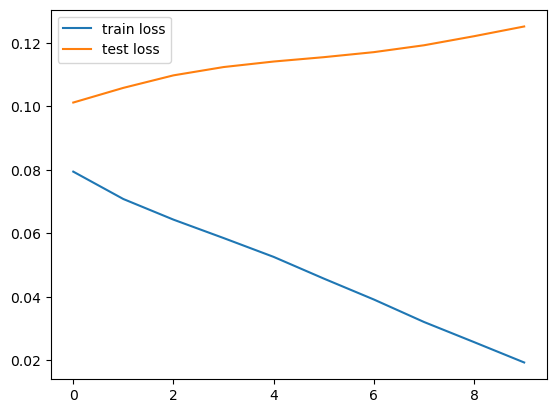

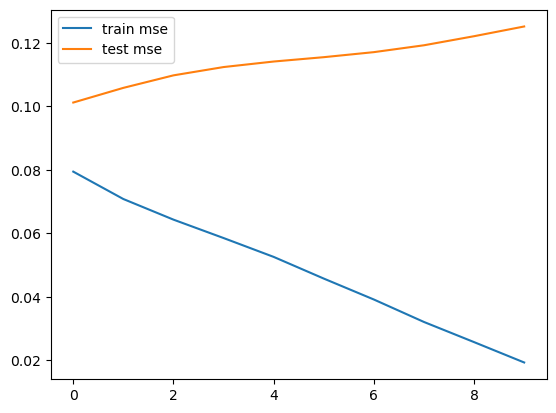

In [25]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

## Otro 1